<h1> Advantage Actor Critic on discrete actions </h1>


<h3> Import dependencies </h3>

In [15]:
import random
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import gymnasium
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
from torch import nn
import cloudpickle
from IPython import display
torch.set_grad_enabled(True) 
%matplotlib inline

<h3> Implementation of A2C </h3>

In [69]:
class ActorCritic(nn.Module):
    
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        self.critic = nn.Sequential(nn.Linear(4,128), nn.Dropout(),
                  nn.ReLU(),
                  nn.Linear(128,1))
        
        self.actor = nn.Sequential(nn.Linear(4,128), nn.Dropout(),
                  nn.ReLU(),
                  nn.Linear(128,2))
    
    def forward(self,state):
        
        v = self.critic(state)
        
        logits = self.actor(state)
        
        return v,logits

    def load(self):
        
        with (open("./models/actor2.pkl","rb") as f1, 
              open("./models/critic2.pkl","rb") as f2):
            
            self.actor = cloudpickle.load(f1)
            self.critic = cloudpickle.load(f2)
    
    def dump(self):
        
        with (open("./models/actor2.pkl","wb") as f1, 
              open("./models/critic2.pkl","wb") as f2):

            cloudpickle.dump(self.actor,f1)
            cloudpickle.dump(self.critic,f2)

In [70]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [71]:
def seed_everything(env1:gymnasium.Env,env2:gymnasium.Env,seed:int):
    
    random.seed(seed)
    torch.manual_seed(seed)
    
    env1.reset(seed=seed)
    env2.reset(seed=seed+1)
    

In [88]:
def init_figs_axes():
    
    fig,ax1 = plt.subplots()
    
    fig.tight_layout(pad=5.0)
    fig.set_figwidth(20)
    fig.set_figheight(8)
      
    return fig,ax1

In [99]:
def plot_graphs(fig:Figure,ax1:Axes,y1,y2):

    ax1.cla()

    ax1.set_title("Episode Length")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Episode Length")
    
    ax1.plot(y1,label="Train")
    ax1.plot(y2,label="Test")
    ax1.legend(loc="lower right")

    ax1.grid()
    
    display.display(fig)
    display.clear_output(wait=True)

In [100]:
def compute_returns(rewards:List,gamma:float):
    
    returns = []
    ret = 0.
    
    for reward in reversed(rewards):
        ret = reward + gamma * ret
        returns.insert(0,ret)
        
    return returns

In [101]:
def critic_loss(returns:List,values:List,critic_loss_fn):
    
    returns = torch.tensor(returns).detach()
    values = torch.cat(values)
    
    loss = critic_loss_fn(returns,values)
    
    return loss

In [102]:
def actor_loss(returns:List,values:List,log_probs:List,entropies:List):
    
    returns = torch.tensor(returns).detach()
    values = torch.cat(values).detach()
    log_probs = torch.cat(log_probs)
    entropies = torch.cat(entropies)
    
    loss = - ((returns - values) * log_probs).mean() - 0.8 * entropies.mean()
    
    return loss

In [103]:
def update_agent(a2c:ActorCritic,rewards:List,values:List,states:List, log_probs:List,entropies:List,gamma:float,optimiser:torch.optim.Optimizer,critic_loss_fn):
    
    a2c.train()
    
    returns = compute_returns(rewards,gamma)
    states = torch.stack(states)
    
    for i in range(5):
        
        optimiser.zero_grad()
        
        values = [a2c(s)[0] for s in states]
        
        l1 = critic_loss(returns,values,critic_loss_fn)
        
        l1.backward()
        
        torch.nn.utils.clip_grad_norm_(a2c.parameters(),50)
        
        optimiser.step()
    
    optimiser.zero_grad()
    
    l2 = actor_loss(returns,values,log_probs,entropies)
    
    l2.backward()
    
    torch.nn.utils.clip_grad_norm_(a2c.parameters(),50)
    
    optimiser.step()

In [104]:
def train_one_episode(env:gymnasium.Env,optimiser:torch.optim.Optimizer,a2c:ActorCritic,gamma:float,critic_loss_fn):
    
    log_probs = []
    values = []
    rewards = []
    entropies = []
    states = []
    
    state,*_ = env.reset()
    state = torch.FloatTensor(state)
    
    while True:
        
        value,logits = a2c(state)
        
        dist = torch.distributions.Categorical(logits=logits)
        
        action = dist.sample().item()
                        
        next_state,reward,terminated,truncated,*_ = env.step(action)
        
        action = torch.FloatTensor([action])
        next_state = torch.FloatTensor(next_state)
        
        log_prob = dist.log_prob(action)
        entropy = dist.entropy().reshape(1,)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(value)
        entropies.append(entropy)
        states.append(state)
        
        state = next_state
        
        if terminated or truncated:
            break
    
    update_agent(a2c,rewards,values,states,log_probs,entropies,gamma,optimiser,critic_loss_fn)
    
    return rewards


In [105]:
def evaluate_one_episode(a2c:ActorCritic,env:gymnasium.Env):
    
    a2c.eval()
    
    state,*_ = env.reset()
    state = torch.FloatTensor(state)
    
    rewards = []
    
    while True:
                
        _,logits = a2c(state)
        
        action = torch.argmax(logits).item()
                
        #action = torch.clamp(action,env.action_space.low[0],env.action_space.high[0])
       
        next_state,reward,terminated,truncated,*_ = env.step(action)
        
        rewards.append(reward)
    
        if terminated or truncated:
            break
            
        state = torch.FloatTensor(next_state)
            
    return rewards

Threshold of 500.0 reached at episode 93


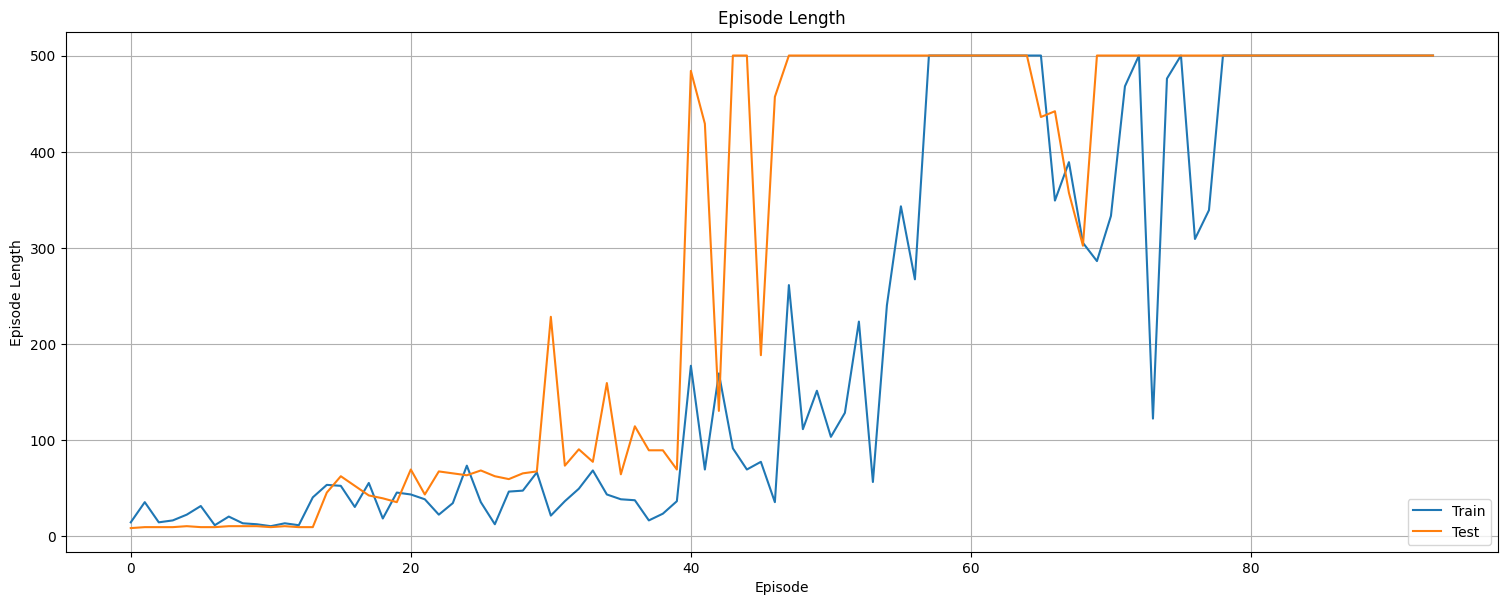

In [109]:
NUM_EPISODES = 1000
ALPHA = 0.01
GAMMA = 0.99
SEED = 12
ROLLING_AVERAGE_SIZE = 25
MEAN_THRESHOLD = 500
PLOT_GRAPHS = True

train_env = gymnasium.make("CartPole-v1")
test_env = gymnasium.make("CartPole-v1")

seed_everything(train_env,test_env,1)

loss = nn.MSELoss()
a2c = ActorCritic()

optimiser = torch.optim.AdamW(a2c.parameters(),lr=ALPHA)

fig,ax1 = init_figs_axes() if PLOT_GRAPHS else (None,None)

train_returns = []
train_ep_lens = []
test_returns = []
test_ep_lens = []

a2c.apply(init_weights)

for i in range(NUM_EPISODES):

  ret1 = train_one_episode(train_env,optimiser,a2c,GAMMA,loss)
  
  ret2 = evaluate_one_episode(a2c,test_env)
  
  train_returns.append(np.sum(ret1))
  test_returns.append(np.sum(ret2))
  train_ep_lens.append(len(ret1))
  test_ep_lens.append(len(ret2))
  
  PLOT_GRAPHS and plot_graphs(fig,ax1,train_returns,test_returns)

  if np.mean(test_returns[-ROLLING_AVERAGE_SIZE:]) >= MEAN_THRESHOLD:
      print("Threshold of",np.mean(test_returns[-ROLLING_AVERAGE_SIZE:]),"reached at episode",i)
      break


In [110]:
list(a2c.parameters())

[Parameter containing:
 tensor([[ 4.8451e-01,  8.3941e-01,  2.4153e+00,  6.5116e-01],
         [ 2.6288e-03, -4.1525e-02,  1.8749e-02, -8.1857e-03],
         [-7.1000e-02, -9.8337e-02,  1.3021e-02, -8.4232e-02],
         [-6.4038e-01,  2.5513e-01, -9.5762e-01,  2.9912e-02],
         [-1.2332e+00,  3.0935e-01, -1.0129e+00,  1.9073e-02],
         [ 3.2263e-01, -2.1764e-01,  1.2269e-01, -2.2846e-02],
         [ 2.4206e-01,  1.0297e-02, -9.3609e-03,  3.3546e-02],
         [ 2.4227e-01,  8.8202e-02,  2.2755e-01, -3.0821e-02],
         [ 2.2831e-01, -3.5680e-02,  1.1237e-01, -2.7321e-01],
         [ 2.4319e-01, -1.5119e-01, -2.2401e-01,  1.4538e-01],
         [ 3.2608e-01, -4.8562e-02, -3.0625e-02, -4.5584e-02],
         [-3.5216e-03,  4.1715e-02, -2.7367e-01,  1.0137e-01],
         [ 2.9477e-01, -1.3414e-01, -1.4152e-02, -1.8480e-01],
         [ 2.9720e-01, -1.1190e-01,  2.6291e-01, -1.7403e-01],
         [ 3.2597e-01, -4.9856e-02, -7.4012e-02, -4.1515e-02],
         [ 6.1009e-01, -2.4394e-

In [112]:
a2c(torch.tensor([0.1,0.1,0.1,0.1]))

(tensor([108.2756], grad_fn=<AddBackward0>),
 tensor([-1.4608,  1.5840], grad_fn=<AddBackward0>))

In [113]:
test_returns[-25:]

[500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0]

In [114]:
a2c.dump()

<h3> Evaluate in human render mode </h3>

In [115]:
# a2c = ActorCritic()
# a2c.load()
env = gymnasium.make("CartPole-v1",render_mode="human")
env.reset(seed=SEED+2)
try:
    for _ in range(10):
        evaluate_one_episode(a2c,env)
except KeyboardInterrupt:
    env.close()
    